In [1]:
import tensorflow as tf

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(physical_devices[1:],'GPU')

tf.executing_eagerly()
print(tf.executing_eagerly())

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math
import random
import time
import functools

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

True


In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

#strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Input data stream

In [3]:
input_params = data = pd.read_table('input_data/condition.txt', header = None)

datasetNo = int(input_params.values[5,2])
n_epochs = int(input_params.values[10,2])
batch_size = int(input_params.values[11,2])
LR =float(input_params.values[12,2])
Lv1_latent_dim = int(input_params.values[13,2])
stride1 = int(input_params.values[14,2])
stride2 = int(input_params.values[15,2])
stride3 = int(input_params.values[16,2])
C1 = int(input_params.values[17,2])
C2 = int(input_params.values[18,2])
C3 = int(input_params.values[19,2])
C4 = int(input_params.values[20,2])
C5 = int(input_params.values[21,2])
alpha = int(input_params.values[22,2])

num_param = int(input_params.values[1,2])
num_time = int(input_params.values[2,2])
num_time_to = int(input_params.values[27,2])
num_node = int(input_params.values[3,2])
num_var = int(input_params.values[4,2])

epoch_read = int(input_params.values[25,2])
epoch_latent = int(input_params.values[26,2])

print('num_param : ', num_param)
print('num_time : ', num_time)
print('num_node : ', num_node)
print('num_var : ', num_var)
print(' ')
print('datasetNo : ', datasetNo)
print('Lv1_epochs : ', n_epochs)
print('Lv1_batch_size : ', batch_size)
print('Lv1_LearningRate : ', LR)
print('Lv1_latent_dim : ', Lv1_latent_dim)

num_param :  10
num_time :  800
num_node :  100
num_var :  1
 
datasetNo :  1
Lv1_epochs :  500000
Lv1_batch_size :  1
Lv1_LearningRate :  0.0002
Lv1_latent_dim :  128


In [4]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

if datasetNo == 1:
    data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
    print(data.shape)
    #print(data)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 2:
    del(data)
    data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 3:
    del(data)
    data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 4:
    del(data)
    data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]
    del(data)


# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 100, 8000)
8000


In [5]:
# validate
data.shape

(1, 100, 8000)

## FOM data type : FOM_data = np.array[param, time, node, var]

In [6]:
FOM_data = np.zeros((num_param, num_node, num_time))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,j,l]=data[i,j,temp]
                
FOM_data.shape

FOM_data_temp = np.zeros((num_param, num_node, num_time))
FOM_data_temp = FOM_data
del FOM_data
num_time = num_time_to
FOM_data = np.zeros((num_param, num_node, num_time))

FOM_data[:,:,0:num_time] = FOM_data_temp[:,:,0:num_time]
del FOM_data_temp

#del data

In [7]:
x_axis = np.linspace(0,num_node,num_node)

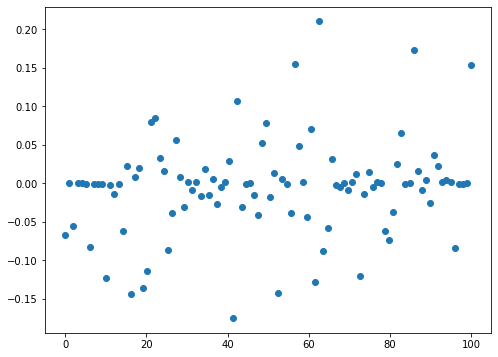

In [8]:
plt.scatter(x_axis, FOM_data[0,:,0])

In [9]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

print(maximum)
print(minimum)
print(mean)
print(AT)

1.8047008785
-2.14637945807875
1.4747403298542849e-15
3.95108033657875


In [10]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT
min_FOM = np.min(FOM_data)
FOM_data = FOM_data-min_FOM

print(np.max(FOM_data))
print(np.min(FOM_data))

1.0
0.0


In [11]:
print(np.max(FOM_data))
print(np.min(FOM_data))

1.0
0.0


In [12]:
FOM_data.shape

(10, 100, 800)

# Level 1, SVAE (spatial VAE)

In [13]:
#Lv1_input = np.zeros((num_param*num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data.reshape(-1, num_node)
Lv1_input.shape
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

(8000, 100)

In [14]:
#validate

#Lv1_input[200,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

In [15]:
Lv1_input_shape = Lv1_input.shape[1:]

In [16]:
print(Lv1_input.shape)
print(Lv1_input_shape)

(8000, 100)
(100,)


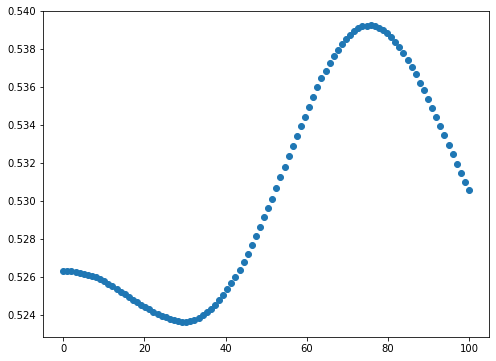

In [17]:
plt.scatter(x_axis, Lv1_input[0,:])

# Acquire latent vectors

In [18]:
# acquire latent vectors for each param and time sets.
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

#del Encoder
#del Decoder

filename1='Lv1_networks/encoder_%d.h5' % (epoch_read)
filename2 = 'Lv1_networks/decoder_%d.h5' % (epoch_read)
Encoder = load_model(filename1)
Encoder.summary()
Decoder = load_model(filename2)
Decoder.summary()

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 800)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 256)          1024256   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 512)          655872    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100, 512)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0   

In [19]:
n_epochs_latent = epoch_latent

In [20]:
FOM_data.shape

(10, 100, 800)

In [21]:
Lv1_input = FOM_data

In [22]:
latent_vector_save=np.zeros([num_param, Lv1_latent_dim])

def find_latent(x_train):
    
    latent_vector = Encoder(x_train, training=False)
    #latent_vector = reparam(mu[-1], var[-1])
    #latent_vector = np.reshape(latent_vector, [-1, Lv1_latent_dim])
    gen_x = Decoder(latent_vector, training=False)
    
    return latent_vector, gen_x

latent_vectors = np.zeros([num_param, Lv1_latent_dim])
latent_vector = np.zeros([1, Lv1_latent_dim])
loss_save = np.ones([num_param])*1000

for i in range(epoch_latent): 
    for j in range(num_param):
        x = FOM_data[j, :,:]
        x = np.reshape(x,(1,x.shape[0],x.shape[1]))
        
        latent_vector, gen_x = find_latent(x)
        
        loss = tf.math.reduce_mean(tf.math.square(x - gen_x))
        
        if loss < loss_save[j]:
            loss_save[j] = loss
            latent_vector_save[j] = latent_vector
            
    del latent_vector
    print('Epoch: {}'.format(i))
    print(loss_save)

Epoch: 0
[3.78033815e-06 5.24376173e-06 5.61257048e-06 7.77494370e-06
 9.21861010e-06 1.08647782e-05 1.43357829e-05 1.39440926e-05
 1.41022056e-05 1.78594346e-05]
Epoch: 1
[3.78033815e-06 5.24376173e-06 5.61257048e-06 7.77494370e-06
 9.21861010e-06 1.08647782e-05 1.43357829e-05 1.39440926e-05
 1.41022056e-05 1.78594346e-05]
Epoch: 2
[3.78033815e-06 5.24376173e-06 5.61257048e-06 7.77494370e-06
 9.21861010e-06 1.08647782e-05 1.43357829e-05 1.39440926e-05
 1.41022056e-05 1.78594346e-05]
Epoch: 3
[3.78033815e-06 5.24376173e-06 5.61257048e-06 7.77494370e-06
 9.21861010e-06 1.08647782e-05 1.43357829e-05 1.39440926e-05
 1.41022056e-05 1.78594346e-05]
Epoch: 4
[3.78033815e-06 5.24376173e-06 5.61257048e-06 7.77494370e-06
 9.21861010e-06 1.08647782e-05 1.43357829e-05 1.39440926e-05
 1.41022056e-05 1.78594346e-05]
Epoch: 5
[3.78033815e-06 5.24376173e-06 5.61257048e-06 7.77494370e-06
 9.21861010e-06 1.08647782e-05 1.43357829e-05 1.39440926e-05
 1.41022056e-05 1.78594346e-05]
Epoch: 6
[3.78033815e-

In [23]:

latent_vectors = latent_vector_save
del latent_vector_save
    
end_param=time.time()

In [24]:
loss_save

array([3.78033815e-06, 5.24376173e-06, 5.61257048e-06, 7.77494370e-06,
       9.21861010e-06, 1.08647782e-05, 1.43357829e-05, 1.39440926e-05,
       1.41022056e-05, 1.78594346e-05])

In [25]:
latent_vectors.shape

(10, 128)

In [26]:
x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)

In [27]:
for_decoder = np.reshape(latent_vectors, [-1, Lv1_latent_dim])

In [28]:
for_decoder.shape

(10, 128)

In [29]:
for_decoder1 = np.zeros([1, Lv1_latent_dim])
for_decoder1[:] = for_decoder[0,:]    # First param
print(for_decoder1.shape)
for_decoder2 = np.reshape(for_decoder1, [-1, Lv1_latent_dim])

(1, 128)


In [30]:
EX = Decoder(for_decoder1)

In [31]:
EX.shape

TensorShape([1, 100, 800])

In [32]:
Lv1_input.shape

(10, 100, 800)

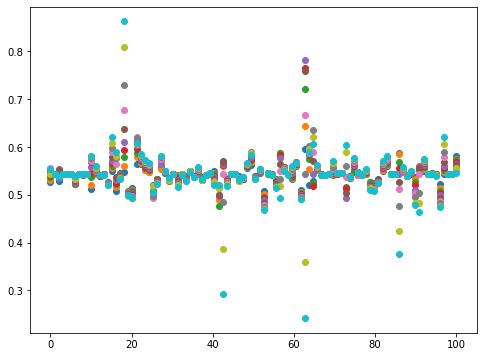

In [33]:
for i in range(num_param):
    plt.scatter(x_axis, Lv1_input[i,:,0])

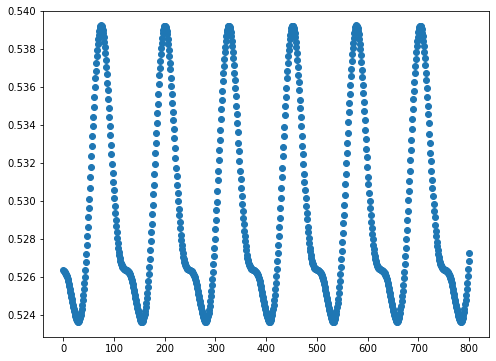

In [34]:
x_axis10=np.linspace(0,num_time,num_time)
plt.scatter(x_axis10, Lv1_input[0,0,:])

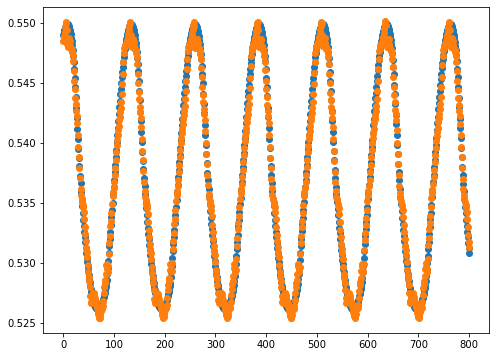

In [35]:
plt.scatter(x_axis10, Lv1_input[0,15,:])
plt.scatter(x_axis10, EX[0,15,:])

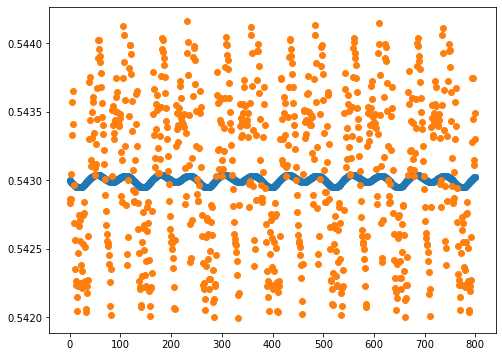

In [36]:
plt.scatter(x_axis10, Lv1_input[0,9,:])
plt.scatter(x_axis10, EX[0,9,:])

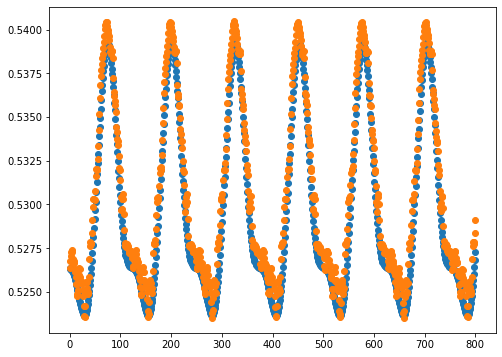

In [37]:
plt.scatter(x_axis10, Lv1_input[0,0,:])
plt.scatter(x_axis10, EX[0,0,:])

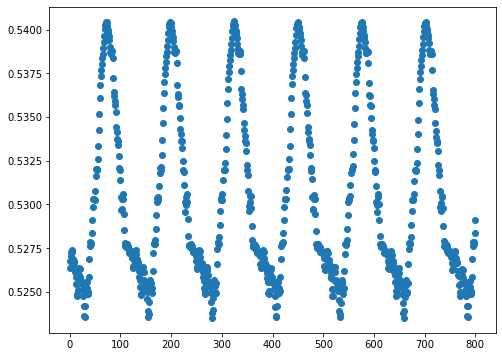

In [38]:
plt.scatter(x_axis10, EX[0,0,:])

In [39]:
x_axis10=np.linspace(0,num_time,num_time)

In [40]:
x_axis10.shape

(800,)

In [41]:
EX.shape

TensorShape([1, 100, 800])

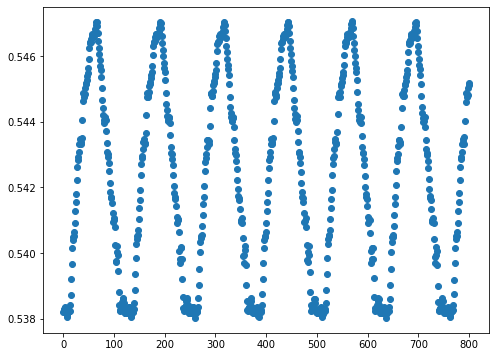

In [42]:
plt.scatter(x_axis10, EX[0,50,:])

In [43]:
x_axis10=np.linspace(0,num_node,num_node)

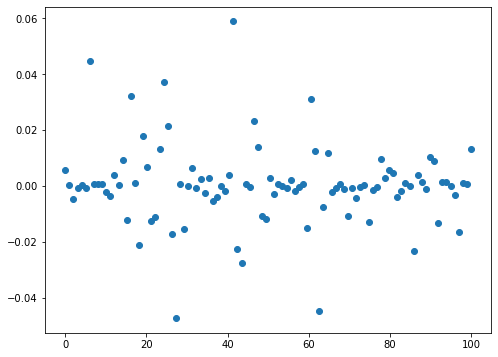

In [44]:
plt.scatter(x_axis, EX[0,:,99]-EX[0,:,0], label = 'ROM')

In [45]:
x_axis.shape

(100,)

ValueError: x and y must be the same size

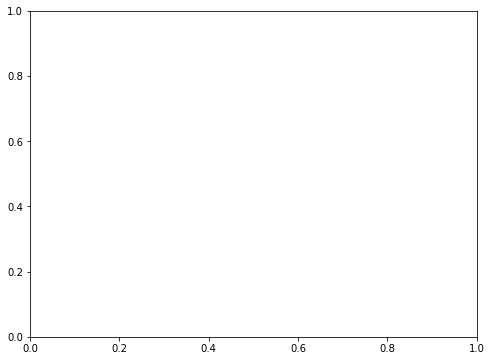

In [46]:

#plt.scatter(x_axis, EX[0,0,:,0], label = 'ROM1')
plt.scatter(x_axis10, Lv1_input[0,0,:], label = 'FOM')
plt.scatter(x_axis10, EX[0,0,:], label = 'ROM')
plt.legend()

# Output latent vectors to file,

In [ ]:
# Save latent vectors for each parameter...

for i in range(num_param):
    filename3 = 'latent_vectors_Lv1/latent_vector_p-s%d' %(i+1)
    np.savetxt(filename3, Lv1_latent[i,:,:], fmt = '%f')

# Move on to TVAE

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.

In [ ]:
FOM_data = np.zeros((num_param, num_node, num_time))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,j,l]=data[i,j,temp]
                
FOM_data.shape

#del datapause;